## Meetup Group Category Predictions

In [1]:
import json
import numpy as np
import pandas as pd
from collections import Counter

import re
from bs4 import BeautifulSoup 

import nltk
from nltk.corpus import stopwords 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from vnessified_naive_bayes import vnessifiedNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

### Introduction
The dataset I've chosen to implement machine learning on for my final project is data I collected for my [Data Engineering project](https://github.com/vnessified/meetup_data) in which I stream, structure, store, and analyze event data from [Meetup.com](https://www.meetup.com/) using their [OpenEvent Stream API](https://www.meetup.com/meetup_api/docs/stream/2/open_events/). 

### Data Source 
Below is an example of what the raw data looks like: 

In [4]:
meetup_json = []

with open('meetup_sample.json', 'r') as f:
    for line in f:
        meetup_json.append(json.loads(line))
        
meetup_json[62]

{'description': "<p>Hi all.</p> \n<p>We play in Sydney Park, on the area known as The Green. The Green is located near the cafe and the children's playground. There are 3 parking lots in the park (does that sound a bit weird to you too?) The park is located across the road from St Peters train station and is on the 422 and 370 bus routes.</p> \n<p>Starting at 3, a gold coin donation is very much appreciated.</p> \n<p>Cheers all.</p>",
 'event_url': 'https://www.meetup.com/Sydney-Volleyball-in-the-Park/events/239795815/',
 'group': {'category': {'id': 32,
   'name': 'sports/recreation',
   'shortname': 'sports-recreation'},
  'city': 'Sydney',
  'country': 'au',
  'group_lat': -33.87,
  'group_lon': 151.21,
  'group_photo': {'highres_link': 'https://secure.meetupstatic.com/photos/event/d/b/5/1/highres_15836145.jpeg',
   'photo_id': 15836145,
   'photo_link': 'https://secure.meetupstatic.com/photos/event/d/b/5/1/600_15836145.jpeg',
   'thumb_link': 'https://secure.meetupstatic.com/photos

The event data Meetup offers is fairly feature rich, providing data on event description, information on the group hosting the event, event venue location, RSVP information, etc. 
(see some basic stats & EDA on the dashboard I created [here](https://s3.amazonaws.com/meetupevents-dashboard/meetupevents-report.html)). To generate the dataset used in the below analysis, I created a subset of the data using Spark to ETL, saved a random sampling (40% of the total data) as a .csv file to work with scikit-learn locally on my computer (trying to save the entire datset as a .csv unfortunately caused memory errors in Spark, which tells me I probably wouldn't have been able to work with it locally on my computer anyway).

### Problem & Goals
To be perfectly honest, my inital goal was a bit uninspired — to predict RVSP count using various features in the data (I probably would've gone with the obvious choice of a simple linear regression to start). I quickly realized this makes almost no sense as the data is streaming, so more often than not, RVSP count is zero (however some events have a RVSP count greater than zero, as is the case in the sample above, this is because modified events are also pushed to the event stream, and so some time has elapsed for people to RVSP). To predict a final RVSP count, I'd have to look historical data and not streaming data. However, I'm actually glad this idea didn't pan out because what I arrived at next is definitely more interesting and gives some credit to the dataset's underlying represenation of human nature — that is the need for connection with others. 

Ultimately, the goal I arrived at is to predict group category based on event description. From a human interest perspective, this goal speaks to how we communicate and how that communication can be condensed and categorized. From a business perspective, being able to predict a group category based on event description could be useful for auto-suggesting tags for events (as of right now, it's my understanding that Meetup events don't even have a tagging functionality). A feature like this would help users discover events they interested in more easily. From a technical perspective, as this is a NLP problem, I make use of the NLTK package as well as scikit-learn's CountVectorizer and TfidfVectorizer feature extraction tools. In terms of model selection, I employ both Random Forest and Naive Bayes as both have been show to perform well with text data. Random Forest seemed especially promising as it's embarrassingly parallelizable, and therefore a good candidate for running on a distributed computing architecture (such as Spark & EMR). However, I ran into issues with trying to fit the model (issues as in always returning an error) and therefore made the switch to a smaller sample of data and scikit-learn for a local implementation. 

### Load Data, Munging & EDA

In [5]:
meetup_raw = pd.read_csv('meetup.csv')
meetup_raw.head(2)

,description,status,event_id,event_name,category
0,<p>FOOD AND FELLOWSHIP | 5 PM</p> \n<p>CONCERT...,upcoming,239660020,We Are Messengers Concert,singles
1,<p><b>【WhyNot!?JAPAN + MeetUp Collaboration Ev...,upcoming,239719229,Friendly Friday!!,socializing


To simplify I'll turn this into a binary classification: "outdoors/adventure" vs "tech".  
1) because they have a sort of duality and 2) because they are roughly balanced.

In [6]:
meetup_raw.category.value_counts()

socializing                 26063
outdoors/adventure          19167
tech                        19161
career/business             18029
health/wellbeing            17534
new age/spirituality        11082
sports/recreation            9217
fitness                      8412
language/ethnic identity     7928
games                        5370
food/drink                   5310
fine arts/culture            4235
dancing                      4224
education/learning           3783
music                        3611
movements/politics           3520
community/environment        3281
singles                      2899
religion/beliefs             2892
parents/family               2537
photography                  2153
hobbies/crafts               1981
movies/film                  1888
support                      1653
LGBT                         1628
book clubs                   1392
writing                      1387
cars/motorcycles             1338
pets/animals                 1123
sci-fi/fantasy

In [7]:
# subsetting my data to only include rows that have category label outdoors/adventure or tech
out_adv = meetup_raw.category == 'outdoors/adventure'; tech = meetup_raw.category == 'tech'
meetup_2cls = meetup_raw[out_adv | tech]
meetup_2cls.category.value_counts()

outdoors/adventure    19167
tech                  19161
Name: category, dtype: int64

In [8]:
# looking for null values
meetup_2cls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38328 entries, 2 to 195318
Data columns (total 5 columns):
description    36401 non-null object
status         38328 non-null object
event_id       38328 non-null object
event_name     38328 non-null object
category       38328 non-null object
dtypes: object(5)
memory usage: 1.8+ MB


In [9]:
# dropping null values... imputing would add more complexity than benefit here I think 
meetup_2cls = meetup_2cls.dropna()
meetup_2cls.shape

(36401, 5)

In [10]:
# binarize category - 0 = outdoors/adventure and 1 = tech
meetup_2cls['category_bin'] = meetup_2cls.category.apply(lambda x: 1 if x == "tech" else 0)
meetup_2cls.head(2)

,description,status,event_id,event_name,category,category_bin
2,<p>TENTATIVE<br></p>\n<p><br></p>\n<p>10.30 - ...,upcoming,239691981,Ansible meetup,tech,1
8,<p>This is an introductory meeting to get to k...,upcoming,mtzxwmywjbjb,Authentication options,tech,1


In [11]:
# clean up and subset to only the columns I'm interested in
meetup_2cls.reset_index(drop=True, inplace=True)
meetup_2cls = meetup_2cls[['description', 'category_bin']]
meetup_2cls.head(2)

,description,category_bin
0,<p>TENTATIVE<br></p>\n<p><br></p>\n<p>10.30 - ...,1
1,<p>This is an introductory meeting to get to k...,1


The below function and my understanding of implementing basic NLP techniques is largely inspired by [this tutorial](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words)

In [12]:
def text_cleaner(text):
    
    '''Cleans out html tags and other non-letter characters with a 
    regular expression and removes stop words'''
    
    # strip html with BeautifulSoup - get_text gives you the text free of html tags
    no_html = BeautifulSoup(text).get_text() 
 
    # just to note: I realize punctuation could have some sentiment meaning 
    # but for simplicity sake I remove punctuation and numbers with this regulur expression 
    letters = re.sub("[^a-zA-Z]", " ", no_html) 

    # tokenize - lower case & split into list where elements are individul words
    raw_words = letters.lower().split()                             

    # NLTK supported languanges - for stop words 
    # stop words = frequency occuring words that don't have much meaning
    langs = ['danish', 'dutch', 'english', 'finnish', 'french', 'german', 'hungarian', 
             'italian', 'norwegian', 'portuguese', 'russian', 'spanish', 'swedish', 'turkish']
    
    # convert stop words into a set because faster to search
    stop_words = set(stopwords.words(langs))                  

    # remove stop words from the data
    words = [word for word in raw_words if not word in stop_words]   
    
    # join words back together
    return( " ".join(words))   

In [13]:
# map the above function elementwise
meetup_2cls['description'] = meetup_2cls.description.map(text_cleaner)

/Users/VanessaG/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/VanessaG/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/Users/VanessaG/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://cst.dk/anders/main.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_

In [14]:
# sanity check
meetup_2cls.head(2)

,description,category_bin
0,tentative introduction orientation session bre...,1
1,introductory meeting get know fellow coders sh...,1


In [15]:
# some basic word stats
print("total words:", 
      sum(meetup_2cls['description'].str.split().map(lambda x: len(x))))
print("average word count per description:", 
      int(sum(meetup_2cls['description'].str.split().map(lambda x: len(x)))/meetup_2cls['description'].shape))

unique_words = set()
meetup_2cls['description'].str.split().map(unique_words.update)
print("total unique words:", len(unique_words))

print("--------------------------------")

wc = Counter()
meetup_2cls['description'].str.split().map(wc.update)
print("top 10 most common words:", wc.most_common(10))

print("--------------------------------")

print("word counts of words used in category label:")
category_label_words = ['tech', 'technology', 'outdoors', 'adventure']

for key in category_label_words:
    print(key, wc.get(key))


total words: 5563323
average word count per description: 152
total unique words: 122548
--------------------------------
top 10 most common words: [('sailing', 59238), ('nations', 36878), ('sailors', 33217), ('please', 30343), ('event', 23489), ('time', 22350), ('day', 21694), ('pm', 21283), ('us', 20960), ('get', 20425)]
--------------------------------
word counts of words used in category label:
tech 3859
technology 4186
outdoors 896
adventure 3162


I think it makes sense to remove words like 'tech', 'technology', 'outdoors', 'outdoors', 'adventure', as they could potentially cause overfitting...

In [16]:
def rm_category_label_words(text):
    
    '''removes words in description that are in the category name'''
    desc_words = text.split()
    
    # words used in category label
    category_label_words = ['tech', 'technology', 'outdoors', 'outdoor', 'adventure']                 

    # remove category label words
    words = [word for word in desc_words if not word in category_label_words]   
    
    # join words back together
    return( " ".join(words))

In [17]:
# map the above function elementwise
meetup_2cls['description'] = meetup_2cls.description.map(rm_category_label_words)

In [18]:
# sanity check
wc2 = Counter()
meetup_2cls['description'].str.split().map(wc2.update)

for key in category_label_words:
    print(key, wc2.get(key))

tech None
technology None
outdoors None
adventure None


In [19]:
# train test split before creating "bag of words"
X = meetup_2cls['description']
y = meetup_2cls['category_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

Initially I tried CountVectorizer, but this gives a count of each word. What I think is better is a frequency, ie normalized counts - so I use TfidfVectorizer.

Some interesting parameters here:
- analyzer determines whether a feature is a word or character n-gram
- tokenizer and preprocessor are set to None as I already did this above
- L1 norm for normalizing the term vectors
- max_features only considers the top 500 features/words by frequency

In [20]:
tf_vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, norm = 'l1',
                                preprocessor = None, max_features = 500)

In [21]:
# each row in the array is a description for an event, each column is a word (ie feature)
# and the element is a normalized count for that particular word and description

X_train_vec_tf = tf_vectorizer.fit_transform(X_train)
X_train_vec_tf = X_train_vec_tf.toarray()

In [22]:
X_train_vec_tf

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01884139,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.07204789],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [23]:
X_train_vec_tf.shape

(27300, 500)

In [24]:
vocab = tf_vectorizer.get_feature_names()
len(vocab)

500

In [25]:
vocab[:4]

['able', 'accommodation', 'across', 'active']

In [26]:
# .vocabulary_ is a dict, where the keys are the words (features) and the values are indices 
# NOT word counts!!
tf_vectorizer.vocabulary_.get('activities')

4

## Model 1 — Random Forest
As mentioned above I implement a Random Forest Classifier here as it has shown to work well in similar NLP problems. I also find the ability to extract feature importance to be very useful.

Additionally, I wanted to gridsearch but it took incredibly long... as in running over 10 minutes and nothing happening but if I were to gridsearch this is how I would do it...

    forest_params = {
        "n_estimators": [50, 100, 150], 
        "max_features": [None, 1, 2, 3, 4, 5],              
        "max_depth": [None, 3, 4, 5],
        "min_samples_split": [2,.05,.25],
         "max_leaf_nodes": [None, 5,6,7]}

    forest_gs = GridSearchCV(forest, forest_params, cv=5, verbose=0, n_jobs=-1)
    forest_gs.fit(X_train_vec, y_train)

    print("Best estimator parameters:", forest_gs.best_params_)
    print("Best CV score:", forest_gs.best_score_)
    print("Best accuracy:", 
    forest_gs.best_estimator_.score(X_train_vec, y_test))

In [27]:
# I tried this with n_estimators = 100 and the default of 10 works just as well
forest = RandomForestClassifier() 
forest = forest.fit(X_train_vec_tf, y_train)

In [28]:
# separately vectorize test set based on norm parameters of train set - hence just .transform
X_test_vec_tf = tf_vectorizer.transform(X_test)
X_test_vec_tf = X_test_vec_tf.toarray()

In [29]:
forest.score(X_test_vec_tf, y_test)

0.95758707834303924

In [30]:
# I like to do these sanity checks
predictions = forest.predict(X_test_vec_tf)
sum(predictions == y_test) / len(y_test)

0.95758707834303924

In [31]:
print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96      4665
          1       0.95      0.96      0.96      4436

avg / total       0.96      0.96      0.96      9101



In [32]:
# comparing actual vs predicted
actual_vs_pred = pd.DataFrame(data={'actual': y_test, 'predicted': predictions})
errors = actual_vs_pred[actual_vs_pred.actual != actual_vs_pred.predicted]

# Recall:
# 0 = outdoors/adventure
# 1 = tech
errors.predicted.value_counts()

1    209
0    177
Name: predicted, dtype: int64

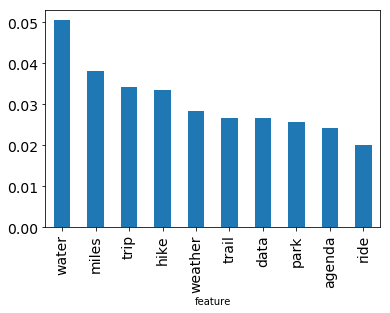

In [33]:
# plot feature importance - important words
feature_importance = pd.DataFrame({
    'feature': vocab,
    'importance': forest.feature_importances_})

important_words = feature_importance.sort_values('importance', ascending=False)

important_words[:10].plot.bar(x="feature", legend=None, figsize=(6, 4), \
                            fontsize=14);

In [41]:
# curious how often these "important" words appear
for key in important_words.feature[:10].tolist():
    print(key, wc.get(key))

water 10284
miles 9848
trip 11943
hike 18166
weather 7522
trail 12122
data 16304
park 13455
agenda 3498
ride 13962


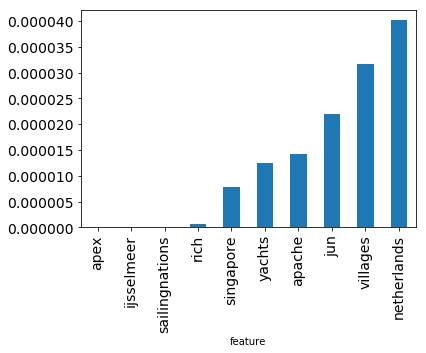

In [43]:
# plot feature importance - unimportant words
feature_importance = pd.DataFrame({
    'feature': vocab,
    'importance': forest.feature_importances_})

unimportant_words = feature_importance.sort_values('importance', ascending=True)

unimportant_words[:10].plot.bar(x="feature", legend=None, figsize=(6, 4), \
                            fontsize=14);

In [44]:
# same idea as for counts of important words but for "unimportant" words 
for key in unimportant_words.feature[:10].tolist():
    print(key, wc.get(key))

apex 2016
ijsselmeer 2416
sailingnations 3767
rich 2770
singapore 2040
yachts 2996
apache 2165
jun 3251
villages 2981
netherlands 2531


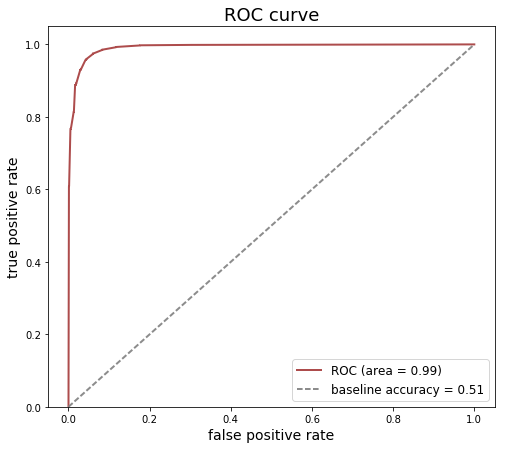

In [45]:
# plot ROC curve - modified from scikit-learn's example: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

predicted_prob = forest.predict_proba(X_test_vec_tf)[:, 1]
fpr_, tpr_, _ = roc_curve(y_test, predicted_prob)
auc_ = auc(fpr_, tpr_)
acc_ = np.abs(0.5 - np.mean(y_test)) + 0.5

fig, ax = plt.subplots(figsize=(8,7))

ax.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_, color='darkred', linewidth=2, alpha=0.7)
ax.plot([0, 1], [0, 1], color='grey', ls='dashed',
         alpha=0.9, linewidth=2, label='baseline accuracy = %0.2f' % acc_)

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('false positive rate', fontsize=14)
ax.set_ylabel('true positive rate', fontsize=14)
ax.set_title("ROC curve", fontsize=18)

ax.legend(loc="lower right", fontsize=12);

## Model 2 — Naive Bayes
As mentioned above, similar to Random Forest, Naive Bayes has been shown to work well for NLP type problems. The Naive Bayes model below is my own implementation of the algorithm and serves also to fulfill the requirement of providing psedocode for a scikit-learn/Spark ML model. I compare it to sckit-learn's multinomial Naive Bayes classifier and in addition to accuracy, also evaluate my Naive Bayes implementation's precision, recall, and f1-score from scikit-learns classification report method.

Here is the code for my implenation of Naive Bayes (from vnessified_naive_bayes.py):

    class vnessifiedNB(object):

        def __init__(self, alpha=1):
            '''
            My own implementation of NaiveBayes
            INPUT:
            - alpha: float, laplace smoothing constant
            '''

            self.class_totals = None
            self.class_feature_totals = None
            self.class_counts = None
            self.alpha = alpha

        def _compute_likelihood(self, X, y):
            '''
            INPUT:
            - X: 2d numpy array, feature matrix
            - y: numpy array, labels

            Compute the totals for each class and the totals for each feature
            and class.
            '''
            # contain the sum of all the features for each class - this is S_y
            self.class_totals = Counter()

            # contain the sum of each feature for each class
            # this is S_yj
            # dictionary of dictionaries (technically a defaultdict of Counters)
            self.class_feature_totals = defaultdict(Counter)

            class_labels = X.shape[0]
            features = X.shape[1]

            # loop through the rows to get the classes
            for class_y in range(class_labels):
                # loop through the columns for the features
                for feature_j in range(features):

                    # for class = 0, sum the corresponding rows - p(class0)
                    # for class = 1, sum the corresponding rows - p(class1)
                    self.class_totals[y[class_y]] += X[class_y, feature_j]

                    # for each row where class = 0, get sum of each individual feature
                    # for each row where class = 1, get sumeof each individual feature
                    # This is essentially like a conditional probability table
                    self.class_feature_totals[y[class_y]][feature_j] += X[class_y, feature_j]

        def fit(self, X, y):
            '''
            INPUT:
            - X: 2d numpy array, feature matrix
            - y: numpy array, labels

            OUTPUT: None
            '''

            # This section is given to you.

            # compute priors
            self.class_counts = Counter(y)

            # compute likelihoods
            self._compute_likelihood(X, y)

        def predict(self, X):
            '''
            INPUT:
            - X: 2d numpy array, feature matrix

            OUTPUT:
            - predictions: numpy array
            '''

            predictions = np.zeros(X.shape[0])

            class_labels = X.shape[0]
            features = X.shape[1]

            # loop through the rows to get the classes
            for class_y in range(class_labels):
                # get class_label count
                class_count = Counter()

                # get the prior probability of classes
                for key, value in self.class_counts.items():
                    prior = Counter()

                    # divide classes by total classes
                    prior[key] = self.class_counts[key] / class_labels

                    # update class_count with log of prior
                    class_count[key] += np.log(prior[key])

                    # for each row in the feature matrix X and for each potential label
                    for feature_j in range(features):

                        # this is just the log likelihoood calcuation:
                        # log(S_yj + alpha / S_y + alpha * p)
                        class_count[key] += X[class_y, feature_j] * np.log(
                            (self.class_feature_totals[key][feature_j] + self.alpha)/
                               (self.class_totals[key] + self.alpha * features))

                # index into class
                predictions[class_y] = class_count.most_common(1)[0][0]

            return predictions

        def score(self, X, y):
            '''
            INPUT:
            - X: 2d numpy array, feature matrix
            - y: numpy array, labels

            OUTPUT:
            - accuracy: float between 0 and 1

            Calculate the accuracy, the percent of documents predicted correctly.
            '''
            return sum(self.predict(X) == y) / float(len(y))

In [46]:
# for my implementation of the model the input must be a numpy array and not a pandas series
y_train_vals = y_train.values
y_test_vals = y_test.values

In [47]:
nb = vnessifiedNB()
nb.fit(X_train_vec_tf, y_train_vals)

In [48]:
# to compare to scikit-learn's implementation
scikit_mnb = MultinomialNB()
scikit_mnb.fit(X_train_vec_tf, y_train_vals)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [49]:
print("My Implementation:")
print('Accuracy:', nb.score(X_test_vec_tf, y_test_vals))
my_predictions =  nb.predict(X_test_vec_tf)


print("sklearn's Implementation")
print('Accuracy:', scikit_mnb.score(X_test_vec_tf, y_test_vals))
sklearn_predictions = scikit_mnb.predict(X_test_vec_tf)

assert np.all(sklearn_predictions == my_predictions)

My Implementation:
Accuracy: 0.927260740578
sklearn's Implementation
Accuracy: 0.927260740578


In [50]:
print(metrics.classification_report(y_test, my_predictions))

             precision    recall  f1-score   support

          0       0.91      0.95      0.93      4665
          1       0.95      0.90      0.92      4436

avg / total       0.93      0.93      0.93      9101



## Final Thoughts...
Both Random Forest and my implementation of NaiveBayes perform extremely well. This could be in large part due to the fact that the feature matrix is 500 columns and so there could be some overfitting taking place. At the same time, exploring the feature importances returned by Random Forest seem very reasonable (ie words like 'water', 'miles', 'trip, 'hike' seem indicative of the category 'outdoor/adventure' whereas 'data' seems indicative of the category 'tech'). Random Forest seems to be a bit more robust, more so in terms of precision and recall compared to Naive Bayes. This makes sense as Random Forest is an ensemble model. Overall I feel confident in the selection of models so much so that I believe if the number of features is reduced to even 50 words, I think a fairly accurate model can still be derived. But this was likely a rudimentary NLP solutions as I'm not all that familiar with that discipline but I'm excited to learn more about it.